# Etapa 1. Turismo de los alpes

El procesamiento de lenguaje natural funciona de varias formas diferentes. El NLP basado en AI involucra el uso de algoritmos de machine learning y técnicas para procesar, comprender y generar lenguaje humano.

## 1. Entendimiento y preparación de los datos

Este es el proceso de limpiar y preparar el texto para que un algoritmo de NLP pueda analizarlo. Algunas técnicas de preprocesamiento de datos comunes incluyen la minería de texto, que toma grandes cantidades de texto y las divide en datos, o la tokenización, que divide el texto en unidades individuales. Estas unidades pueden ser puntuación, palabras o frases. La eliminación de palabras vacías es una herramienta que elimina palabras comunes y artículos del discurso que no son muy útiles en el análisis. La derivación y lematización descomponen las palabras hasta su forma raíz básica, lo que facilita identificar su significado. El etiquetado de categoría gramatical identifica sustantivos, verbos, adjetivos y otras categorías en una oración. El parseo analiza la estructura de una oración y cómo las distintas palabras se relacionan entre sí. [1]

### 1.1 Importación de librerías

In [52]:
import pandas as pd
import numpy as np
import re
import random
import unicodedata
#Natural Toolkit Language
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from nltk.tokenize import word_tokenize
from langdetect import detect

from sklearn.pipeline import Pipeline

### 1.2 Entendimiento de los datos

In [2]:
#Natural Language Toolkit
nltk.download('stopwords')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


True

In [3]:
df = pd.read_csv('tipo1_entrenamiento_estudiantes.csv')

In [4]:
df.head(20)

,Review,Class
0,Nos alojamos en una casa alquilada en la ciuda...,4
1,"La comida está bien, pero nada especial. Yo te...",3
2,"En mi opinión, no es una como muchos usuarios ...",3
3,esta curiosa forma que asemeja una silla de mo...,4
4,Lo mejor era la limonada. Me gusto la comida d...,2
5,Carol K. \r\n\r\nNo me sorprende que el coment...,2
6,Nos gustó mucho pero hicimos fila enorme para ...,4
7,Un hotel muy limpio con un personal de segurid...,1
8,"Subiendo las escaleras, puede encontrar un bar...",4
9,"Llegamos el 17 de febrero, hicimos el check in...",1


In [5]:
df.describe()

,Class
count,7875.000000
mean,3.491683
std,1.328275
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [6]:
len(df)

7875

Lo anterior muestra una muestra de los datos, con una cantidad total de reseñas de 7875 y se encontraron que muchas palabras estan mal escritas o escritas coloquialmente como es pq y q, que son respectivamente porque y que, asimismo, las palabras con tildes estan mal escritas como es: estÃ¡

A continuación identificamos los datos duplicados y datos nulos, donde no se mostraron que no se encontraron. 

In [7]:
# Conteo de datos duplicados
duplicados = df.duplicated().sum()
print("Cantidad de datos duplicados:", duplicados)

# Conteo de datos nulos por columna
nulos_por_columna = df.isnull().sum()
print("Cantidad de datos nulos por columna:")
print(nulos_por_columna)


Cantidad de datos duplicados: 71
Cantidad de datos nulos por columna:
Review    0
Class     0
dtype: int64


<Axes: xlabel='Class'>

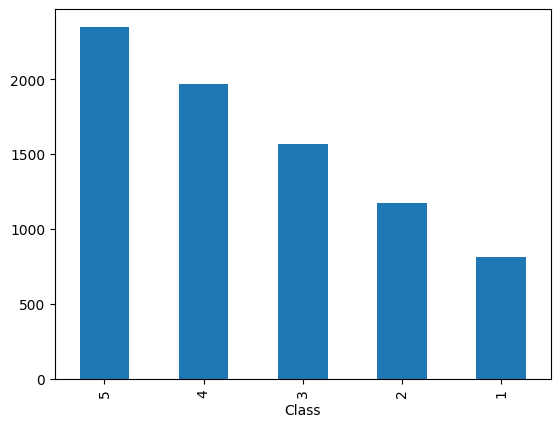

In [8]:
df["Class"].value_counts().plot(kind='bar')

Se observó en la gráfica que hay más calificaciones ("reviews") fue 5, y el última fue 1. 

c:\Users\user\BI-Sabroson\Proyecto1_Etapa1\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


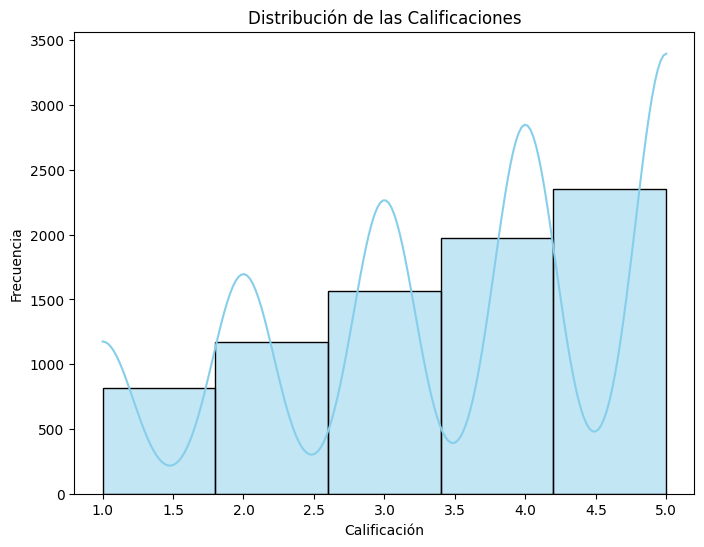

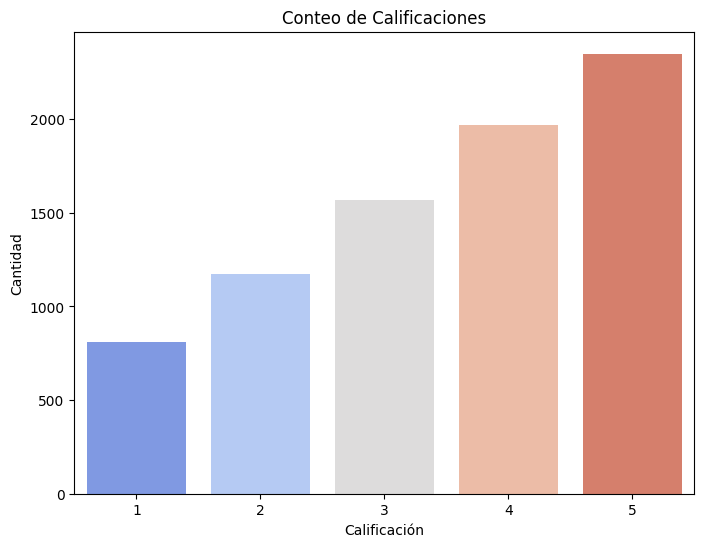

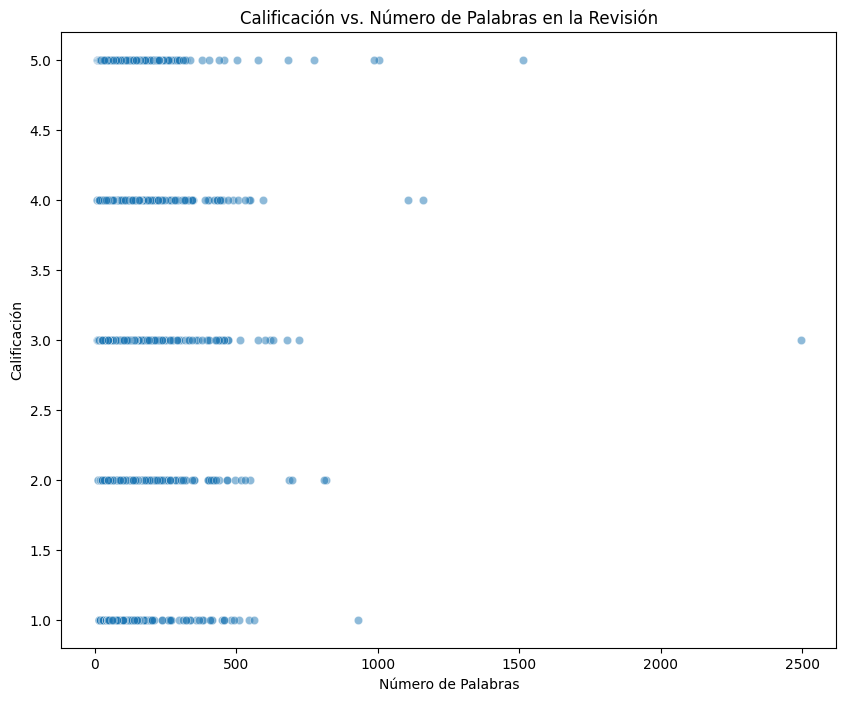

In [9]:
# Histograma de las calificaciones
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Class', bins=5, kde=True, color='skyblue')
plt.title('Distribución de las Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras de las calificaciones
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Class', palette='coolwarm')
plt.title('Conteo de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Cantidad')
plt.show()

# Diagrama de dispersión de las calificaciones en función del número de palabras en la revisión
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x=df['Review'].apply(lambda x: len(x.split())), y='Class', alpha=0.5)
plt.title('Calificación vs. Número de Palabras en la Revisión')
plt.xlabel('Número de Palabras')
plt.ylabel('Calificación')
plt.show()

In [10]:
profile = ProfileReport(df)
profile.to_file("data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Por último se realiza un análisis al texto de las reseñas

In [11]:
df['Review'].head()

0    Nos alojamos en una casa alquilada en la ciuda...
1    La comida está bien, pero nada especial. Yo te...
2    En mi opinión, no es una como muchos usuarios ...
3    esta curiosa forma que asemeja una silla de mo...
4    Lo mejor era la limonada. Me gusto la comida d...
Name: Review, dtype: object

In [12]:

# Se eliminan las reseñas con más de 500 palabras
df = df[df['Review'].apply(lambda x: len(x) <= 500)]
df_filtered = df.copy()

In [13]:
# Length of each text entry
df_filtered['text_length'] = df_filtered['Review'].apply(lambda x: len(x))
df_filtered.describe()

,Class,text_length
count,5895.000000,5895.000000
mean,3.656828,247.256997
std,1.288062,96.936661
min,1.000000,33.000000
25%,3.000000,172.000000
50%,4.000000,237.000000
75%,5.000000,298.000000
max,5.000000,500.000000


In [14]:

# Number of words in each text entry
df_filtered['word_count'] = df_filtered['Review'].apply(lambda x: len(word_tokenize(x)))

# Average length of text entries
average_text_length = df_filtered['text_length'].mean()

# Summary statistics of text lengths
text_length_stats = df_filtered['text_length'].describe()

# Print or use these statistics as needed
print("Average text length:", average_text_length)

print("Summary statistics of text lengths:\n", text_length_stats)

Average text length: 247.25699745547072
Summary statistics of text lengths:
 count    5895.000000
mean      247.256997
std        96.936661
min        33.000000
25%       172.000000
50%       237.000000
75%       298.000000
max       500.000000
Name: text_length, dtype: float64


### 1.2 Preparación de los datos

Primero se van a escribir las decisiones de transformación y preparación de los datos y posteriormente se realizará cada uno.

Decisión 1: Eliminación de duplicados 

Se procede a eliminar los duplicados pero manteniendo uno de estos registros para igual tenerlo en cuenta en el análisis.

In [15]:
df = df.drop_duplicates(keep='first')

Decisión 2: Traducción

Se decide verificar el idioma enel que esta

In [16]:
df['idioma']=df['Review'].apply(detect)
idiomas = df['idioma'].value_counts(normalize=True)
idiomas

idioma
es    0.999486
en    0.000343
pt    0.000171
Name: proportion, dtype: float64

In [17]:
df=df[df['idioma']=='es']
df.describe()

,Class
count,5828.000000
mean,3.667982
std,1.281714
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


Decisión 3: Limpieza de caracteres

Se limpian todas las reseñas de símbolos y se convierten en minúsculas. Esto debido a que las mayúsculas no se consideran como información valiosa y tildes mal puestas. 

In [18]:

def preprocessor(text):
    # Eliminar etiquetas HTML
    text = re.sub('<[^>]*>', '', text)
    
    # Eliminar tildes y otros caracteres especiales
    text = ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Encontrar emoticones
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    # Eliminar caracteres no alfanuméricos y agregar emoticones
    text = re.sub('[\W]+', ' ', text) + ' '.join(emoticons).replace('-', '')
    
    return text.split()

In [19]:
df['Review'] = df['Review'].apply(preprocessor)

In [20]:
df.head()

,Review,Class,idioma
0,"[nos, alojamos, en, una, casa, alquilada, en, ...",4,es
1,"[la, comida, esta, bien, pero, nada, especial,...",3,es
3,"[esta, curiosa, forma, que, asemeja, una, sill...",4,es
4,"[lo, mejor, era, la, limonada, me, gusto, la, ...",2,es
5,"[carol, k, no, me, sorprende, que, el, comenta...",2,es


Decisión 4: Con el Natural Language Toolkit se procede a eliminar las palabras que no tienen gran significado para este análisis, estas son palabras como: articulos, preposiciones, pronombres, entre otros. Que de igual manera no nos brindan información de gran utilidad pues en muchos casos son neutros o no aportan mucho.

In [21]:
#Se utiliza el filtro de stopwords en español
stop = stopwords.words('spanish')

def remove_stopwords(text):
    tokenized = [w for w in text if w not in stop]
    return tokenized

In [22]:
df['Review'] = df['Review'].apply(remove_stopwords)

Decisión 5: Creación de vocabulario y conteo de ocurrencias

Crear un vocabulario de todas las palabras presentes en las reseñas del conjunto de entrenamiento. El vocabulario se crea contando cuántas veces aparece cada palabra en todas las reseñas.

In [23]:
from collections import Counter
#Se cuentan las ocurrencias de las palabras en todas las reseñas
vocabulary = Counter()

for review in df['Review']:
    vocabulary.update(review)

In [24]:
#Se muestran las 5 palabras mas comunes
vocabulary.most_common()[:5]

[('mas', 1932),
 ('lugar', 1588),
 ('hotel', 1384),
 ('comida', 1381),
 ('servicio', 1155)]

In [25]:
len(vocabulary)

15375

Decisión 6: Normalización

Se procede a normalizar las palabras al hacer uso de stemming y lematización.

Stemming

In [26]:

data = df.copy()

stemmer = SnowballStemmer('spanish')

def stem_words(words):
    return [stemmer.stem(word) for word in words]

def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split(" ")])

data['tokens'] = data['Review'].apply(stem_words)

sample_indices = random.sample(range(len(data)), 5)
sample_data = data['Review'].iloc[sample_indices]

# Create a new Series to store the stemmed tokens
sample_data_stemmed = sample_data.apply(stem_words)

# Iterate over the sample data and print original and stemmed tokens
for idx, original_review in sample_data.items():
    print("Original:")
    print(original_review)
    print("\nDespués del stemming:")
    print(sample_data_stemmed[idx])
    print("\n---------------------------------\n")


Original:
['si', 'habana', 'vieja', 'podes', 'dejar', 'recorrer', 'paseo', 'prado', 'podes', 'ver', 'artistas', 'pintan', 'temas', 'cubanos', 'nace', 'malecon', 'finaliza', 'centro', 'habana', 'cuadra', 'capitolio', 'teatro', 'nacional', 'costados', 'puede', 'comer', 'menu', 'bueno', '10', 'cuc', 'si', 'vas', 'vedado', 'autos', 'antiguos', 'cobran', '10', 'pesos', 'cubanos', 'persona', 'recorrido', 'finaliza', 'termina', 'paseo', 'prado']

Después del stemming:
['si', 'haban', 'viej', 'pod', 'dej', 'recorr', 'pase', 'prad', 'pod', 'ver', 'artist', 'pint', 'tem', 'cuban', 'nac', 'malecon', 'finaliz', 'centr', 'haban', 'cuadr', 'capitoli', 'teatr', 'nacional', 'cost', 'pued', 'com', 'menu', 'buen', '10', 'cuc', 'si', 'vas', 'ved', 'aut', 'antigu', 'cobr', '10', 'pes', 'cuban', 'person', 'recorr', 'finaliz', 'termin', 'pase', 'prad']

---------------------------------

Original:
['subimos', 'cerro', 'monserrat', 'teleferico', 'viaje', 'mismo', 'atractivo', 'dado', 'trayecto', 'realiza', '

Lemmatizing

In [27]:
data2=df.copy()
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

data2['tokens'] = data2['Review'].apply(lemmatize_words)

# Muestra aleatoria de ejemplos
sample_indices = random.sample(range(len(data2)), 5)
sample_data = data2.iloc[sample_indices]

# Función de lematización a los ejemplos seleccionados
sample_data['lemmatized_tokens'] = sample_data['Review'].apply(lemmatize_words)

# Ejemplos antes y después de la lematización
for index, row in sample_data.iterrows():
    print("Original:")
    print(row['Review'])
    print("\nDespués de la lematización:")
    print(row['lemmatized_tokens'])
    print("\n---------------------------------\n")

Original:
['perfecto', 'estancia', 'bien', 'masajistas', 'hotel', 'trataron', 'perfecto', 'habitacion', 'deseaba', 'cool']

Después de la lematización:
['perfecto', 'estancia', 'bien', 'masajistas', 'hotel', 'trataron', 'perfecto', 'habitacion', 'deseaba', 'cool']

---------------------------------

Original:
['encanto', 'senti', 'atrapada', 'muros', 'noche', 'ceremonia', 'canonazo', 'divinoes', 'tercer', 'viaje', 'cuba', 'primera', 'visita', 'morro', 'pierdan', 'entrada', '8', 'cuc', 'si', 'queres', 'ver', 'mejor', 'ceremonia', 'abonan', '2', 'cuc', 'adicionales', 'sentarte', 'palco', 'incluye', 'sandwich', 'trago']

Después de la lematización:
['encanto', 'sent', 'atrapada', 'muros', 'noche', 'ceremonia', 'canonazo', 'divinoes', 'tercer', 'viaje', 'cuba', 'primera', 'visita', 'morro', 'pierdan', 'entrada', '8', 'cuc', 'si', 'queres', 'ver', 'mejor', 'ceremonia', 'abonan', '2', 'cuc', 'adicionales', 'sentarte', 'palco', 'incluye', 'sandwich', 'trago']

--------------------------------

C:\Users\user\AppData\Local\Temp\ipykernel_35564\3842828637.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['lemmatized_tokens'] = sample_data['Review'].apply(lemmatize_words)


Decisión 6: Separación dataframe en train y test

Se separan diferentes tipos de Datasets debido a que se trataron diferentes manera de tratar los datos, cuando se encuentre la mejor combinación de decisiones de transformación será la utilizada en los cálculos

In [40]:

X, Y = df['Review'], df['Class']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,Y,
                                        train_size = 0.90,
                                        random_state=0
                                        ) 

En esta separación solo se realizará la transformación de las palabras utilizando Stemming 

In [28]:
new = data.copy()

X, Y = new['Review'], new['Class']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
                                        X,Y,
                                        train_size = 0.90,
                                        random_state=0
                                        ) 

En esta separación solo se realizará la transformación de las palabras utilizando Lemmatizing

In [29]:
new = data2.copy()

X, Y = new['Review'], new['Class']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
                                        X,Y,
                                        train_size = 0.90,
                                        random_state=0
                                        ) 

Decisión 7: Vectorización de texto. 

Este paso se realiza debido a que, muchos algoritmos de aprendizaje automático, como las redes neuronales y las máquinas de vectores de soporte (SVM), requieren que las entradas sean en forma numérica. La vectorización convierte el texto en vectores numéricos que pueden ser utilizados por estos algoritmos para entrenar modelos.

In [58]:
# Unir los tokens en cadenas de texto
X_train_str = [' '.join(tokens) for tokens in X_train_s]
X_test_str = [' '.join(tokens) for tokens in X_test_s]

X_train_str_l = [' '.join(tokens) for tokens in X_train_l]
X_test_str_l = [' '.join(tokens) for tokens in X_test_l]

X_train_str_normal = [' '.join(tokens) for tokens in X_train]
X_test_str_normal = [' '.join(tokens) for tokens in X_test]

# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_v = tfidf_vectorizer.fit_transform(X_train_str)
X_test_v = tfidf_vectorizer.transform(X_test_str)

X_train_v_l = tfidf_vectorizer.transform(X_train_str_l)
X_test_v_l = tfidf_vectorizer.transform(X_test_str_l)

X_train_v_normal = tfidf_vectorizer.transform(X_train_str_normal)
X_test_v_normal = tfidf_vectorizer.transform(X_test_str_normal)


In [31]:
# Convertir matriz dispersa a DataFrame
X_train_df = pd.DataFrame(X_train_v.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Imprimir un preview grande del DataFrame
print(X_train_df.head(10))

    00  000   10  100   11   12   13   14   15  150  ...  yucatecos  zapatos  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...        0.0      0.0   

   zaragoza  zarandeado  zipaquira  zocalo  zona  zonas  zoologico  zumo  
0       0.0         0.0        0.0     0.0  

Los valores en la tabla representan el peso TF-IDF de cada palabra en cada revisión. TF-IDF es una medida estadística que evalúa la importancia de una palabra en un documento en relación con un corpus de documentos. Un valor alto indica que la palabra es importante para esa revisión específica, mientras que un valor bajo indica que la palabra es menos relevante. Por el contrario, las palabras con un valor de TF-IDF bajo o cercano a cero pueden no ser tan relevantes para esa revisión en particular.

Por ejemplo, en la primera fila, la palabra "zona" tiene un valor de TF-IDF de aproximadamente 0.105923, lo que sugiere que esta palabra es relativamente importante en esa revisión específica en comparación con otras palabras en esa revisión y en el corpus general de revisiones.

## 2. Modelado

### 2.1 Support Vector Machine (SVM)

Maria Alejandra Estrada García 

202021060

Para esto primero se va a realizar un análisis de sentimientos usando Clasificación de Texto con SVM. Para analizar las reseñas de los sitios turísticos y determinar el sentimiento asociado con cada una (positivo, neutral, negativo). Esto permitiría identificar características específicas que influyen en la satisfacción del turista y determinar qué aspectos contribuyen a la popularidad de un sitio turístico y cuáles afectan su reputación negativamente. En otras palabras, un SVM lleva a cabo la clasificación encontrando el hiperplano que maximiza el margen entre clases. Los vectores (muestras) que definen el hiperplano (decision boundary) son los vectores de soporte. Por otro lado, todas las muestras ubicadas a un lado de la frontera de decisión serán clasificadas con valores positivos igual o mayores que uno. Análogamente, todas las muestras ubicadas al otro lado de la frontera de deción serán clasificadas con valores negativos iguales o menores que menos uno. 

### 2.1.1 Búsqueda de hiperparámetros

Para realizar la visualización de los datos y las diferentes clases junto con los support vectors en un SVM, primero necesitamos ajustar los hiperparámetros adecuados para cada tipo de kernel (lineal y RBF). Luego, podemos utilizar técnicas de reducción de dimensionalidad como PCA para visualizar los datos en un espacio bidimensional. Después de eso, podemos entrenar los modelos SVM con los datos reducidos y visualizar las diferentes clases junto con los vectores de soporte.

Para la elección del kernel depende de la naturaleza de los datos y del problema en cuestión. Adicionalmente, ajustar el parámetro de regularización es importante para controlar el compromiso entre la complejidad del modelo y su capacidad para generalizar.  El parámetro gamma tiene un efecto significativo en la forma del límite de decisión. 

Ajuste de hiperparámetros para SVM con kernel lineal

In [46]:
# Definir los parámetros a ajustar
parameters_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Crear una instancia del clasificador SVM con kernel lineal
svm_linear = SVC(kernel='linear', random_state=42)

# Crear una instancia de GridSearchCV
grid_search_linear = GridSearchCV(svm_linear, parameters_linear, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Realizar la búsqueda de hiperparámetros
grid_search_linear.fit(X_train_v, y_train_s)

# Obtener los mejores hiperparámetros
best_params_linear = grid_search_linear.best_params_
print("Mejores hiperparámetros para SVM con kernel lineal:", best_params_linear)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros para SVM con kernel lineal: {'C': 1}


El valor óptimo encontrado para el parámetro de regularización C es de 1 que indica que el modelo busca un equilibrio entre clasificar correctamente los puntos de entrenamiento y mantener una buena capacidad de generalización en nuevos datos.

Ajuste de hiperparámetros para SVM con kernel RBF

In [45]:
# Escalar los datos utilizando MaxAbsScaler
scaler_rbf = MaxAbsScaler()
X_train_scaled_rbf = scaler_rbf.fit_transform(X_train_v)

# Definir los parámetros a ajustar
parameters_rbf = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

# Crear una instancia del clasificador SVM con kernel RBF
svm_rbf = SVC(kernel='rbf', random_state=42)

# Crear una instancia de GridSearchCV
grid_search_rbf = GridSearchCV(svm_rbf, parameters_rbf, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Realizar la búsqueda de hiperparámetros
grid_search_rbf.fit(X_train_scaled_rbf, y_train_s)

# Obtener los mejores hiperparámetros
best_params_rbf = grid_search_rbf.best_params_
print("Mejores hiperparámetros para SVM con kernel RBF:", best_params_rbf)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros para SVM con kernel RBF: {'C': 10, 'gamma': 0.01}


### 2.1.2 Precición de los modelos

SVM usando Kernel Linear:

Se usan los hiperparámetros encontrados anteriormente (C=1.0)

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Crear una instancia del clasificador SVM con kernel lineal
svm_linear = SVC(kernel='linear', C=1, random_state=42)

# Entrenar el modelo SVM con kernel lineal
svm_linear.fit(X_train_v, y_train_s)

# Realizar predicciones sobre el conjunto de prueba
y_pred_linear = svm_linear.predict(X_test_v)

# Evaluar la precisión del modelo
accuracy_linear = accuracy_score(y_test_s, y_pred_linear)
print("Precisión del modelo SVM con kernel lineal:", accuracy_linear)

#Evaluar F1 Score
print("\nF1 Score del modelo SVM con kernel lineal:", f1_score(y_test_s, y_pred_linear, average='weighted'))

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test_s, y_pred_linear))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_s, y_pred_linear))


Precisión del modelo SVM con kernel lineal: 0.483704974271012

F1 Score del modelo SVM con kernel lineal: 0.4690382453803604

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.48      0.27      0.34        49
           2       0.41      0.22      0.29        76
           3       0.36      0.39      0.37       106
           4       0.45      0.45      0.45       168
           5       0.58      0.73      0.65       184

    accuracy                           0.48       583
   macro avg       0.46      0.41      0.42       583
weighted avg       0.47      0.48      0.47       583


Matriz de Confusión:
[[ 13  12  10   7   7]
 [ 13  17  28  13   5]
 [  1   7  41  36  21]
 [  0   4  23  76  65]
 [  0   1  11  37 135]]


El modelo SVM con kernel lineal tiene una precisión del 46.7%. Sin embargo, su rendimiento varía entre las diferentes clases, siendo más bajo para las clases 1, 2 y 3 en comparación con las clases 4 y 5. Esto sugiere que el modelo podría beneficiarse de mejoras o de la consideración de otras técnicas de clasificación para lograr un rendimiento más equilibrado entre las clases.

SVM usando Kernel RBF:

Vectorizing:

In [66]:
# Preprocesar los datos (escalar para el kernel RBF)
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_v)
X_test_scaled = scaler.transform(X_test_v)

# Crear una instancia del clasificador SVM con kernel RBF
svm_rbf = SVC(kernel='rbf', C=10.0, gamma=0.01, random_state=42)

# Entrenar el modelo SVM con kernel RBF
svm_rbf.fit(X_train_scaled, y_train_s)

# Realizar predicciones sobre el conjunto de prueba
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# Evaluar la precisión del modelo
accuracy_rbf = accuracy_score(y_test_s, y_pred_rbf)
print("Precisión del modelo SVM con kernel RBF:", accuracy_rbf)

#Evaluar F1 Score
print("\nF1 Score del modelo SVM con kernel lineal:", f1_score(y_test_s, y_pred_rbf, average='weighted'))

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test_s, y_pred_rbf))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_s, y_pred_rbf))

Precisión del modelo SVM con kernel RBF: 0.4648370497427101

F1 Score del modelo SVM con kernel lineal: 0.4534432099066183

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.48      0.29      0.36        49
           2       0.45      0.25      0.32        76
           3       0.36      0.40      0.38       106
           4       0.41      0.40      0.41       168
           5       0.56      0.70      0.62       184

    accuracy                           0.46       583
   macro avg       0.45      0.41      0.42       583
weighted avg       0.46      0.46      0.45       583


Matriz de Confusión:
[[ 14  10  10   7   8]
 [ 13  19  27  13   4]
 [  2   7  42  36  19]
 [  0   5  24  68  71]
 [  0   1  13  42 128]]


### 2.2 Random Forest

Marilyn Stephany Joven Fonseca

202021346

Este método se basa en la construcción de múltiples árboles de decisión durante el entrenamiento y combina sus predicciones para obtener una predicción más precisa y robusta. En nuestro contexto, Random Forest nos permitirá identificar las características más relevantes que inciden en la satisfacción del turista y la popularidad de los destinos turísticos. Al evaluar la importancia de variables como la ubicación, las instalaciones, los servicios y las reseñas de los turistas, seremos capaces de descubrir patrones y tendencias que contribuyan a entender mejor qué aspectos determinan el éxito de un sitio turístico.

#### 2.2.1 Búsqueda de hiperparámetros


A continuación se buscarán los mejores hiperparámetros para el Random forest. Los hiperparámetros seleccionados para la búsqueda de la mejor configuración del modelo de RandomForest ofrecen una amplia gama de opciones que abarcan diferentes aspectos clave del algoritmo. La variación en el número de estimadores, que incluye valores como 100, 200, 300 y 500, permite evaluar cómo el aumento en la complejidad del modelo afecta su rendimiento. La consideración de la profundidad máxima de los árboles, con opciones que van desde no imponer restricciones hasta limitar la profundidad a valores como 20, 30 y 40, permite sopesar el equilibrio entre la capacidad de generalización y el riesgo de sobreajuste. Además, la variación en el número mínimo de muestras requeridas para dividir un nodo, con valores como 2, 5 y 10, permite explorar cómo la complejidad de la partición de los árboles afecta la capacidad del modelo para capturar patrones en los datos. En conjunto, esta selección de hiperparámetros proporciona una exploración exhaustiva de las configuraciones clave que pueden influir en el rendimiento del modelo RandomForest, permitiendo identificar la combinación óptima para el conjunto de datos dado.

In [68]:

steps_rf = [
    ('classifier', RandomForestClassifier(random_state=42))
]
pipeline_rf = Pipeline(steps=steps_rf)
param_grid_rf = {
    'classifier__n_estimators': [200,300,500,1000],  # Número de árboles para RandomForest
    'classifier__max_depth': [None, 20,30,40],      # Profundidad máxima de los árboles
    'classifier__min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)


Ahora se realizará el GridSearch con los hiperparámetros configurados

In [73]:
%%time
grid_search_rf.fit(X_train_v_normal, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 7.56 s
Wall time: 3min 57s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 20, 30, 40],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [200, 300, 500, 1000]},
             scoring='accuracy', verbose=2)

In [76]:
pd.DataFrame(grid_search_rf.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,20.169139,0.659403,0.213366,0.008928,None,5,500,"{'classifier__max_depth': None, 'classifier__m...",0.470925,0.483317,0.460439,0.431840,0.474738,0.464252,0.017794,1
11,34.761503,1.378894,0.453744,0.039601,None,10,1000,"{'classifier__max_depth': None, 'classifier__m...",0.463298,0.482364,0.463298,0.438513,0.469971,0.463489,0.014298,2
7,40.874134,1.386022,0.454690,0.021796,None,5,1000,"{'classifier__max_depth': None, 'classifier__m...",0.462345,0.486177,0.461392,0.433746,0.469971,0.462726,0.016995,3
2,27.230496,1.141084,0.267075,0.034585,None,2,500,"{'classifier__max_depth': None, 'classifier__m...",0.463298,0.470925,0.465205,0.429933,0.482364,0.462345,0.017516,4
1,15.550304,1.010525,0.202812,0.060523,None,2,300,"{'classifier__max_depth': None, 'classifier__m...",0.471878,0.474738,0.460439,0.429933,0.472831,0.461964,0.016780,5


In [77]:
best_model_rf = grid_search_rf.best_estimator_
grid_search_rf.best_params_

{'classifier__max_depth': None,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 500}

In [80]:
# Realizar predicciones sobre el conjunto de prueba
y_pred_rf = best_model_rf.predict(X_test_v_normal)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred_rf)
print("Precisión del modelo Random Forest:", accuracy)

#Evaluar F1 Score
print("\nF1 Score del modelo Random Forest:", f1_score(y_test, y_pred_rf, average='weighted'))

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))

Precisión del modelo Random Forest: 0.43567753001715265

F1 Score del modelo Random Forest: 0.39923222613257464

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.50      0.12      0.20        49
           2       0.40      0.24      0.30        76
           3       0.30      0.23      0.26       106
           4       0.47      0.33      0.38       168
           5       0.46      0.82      0.59       184

    accuracy                           0.44       583
   macro avg       0.43      0.35      0.35       583
weighted avg       0.43      0.44      0.40       583


Matriz de Confusión:
[[  6  15   7   6  15]
 [  5  18  21   6  26]
 [  1   9  24  27  45]
 [  0   3  19  55  91]
 [  0   0   9  24 151]]


### 2.3 Logistic Regression

Santiago Martínez Novoa

202112020

Este algoritmo estima las probabilidades asociadas con cada clase y utiliza una función logística para predecir la probabilidad de que una instancia pertenezca a una clase específica. En nuestro análisis turístico, la Regresión Logística nos permitirá predecir la probabilidad de que un sitio turístico reciba una calificación positiva, neutral o negativa en función de sus características específicas. Esto nos ayudará a identificar qué factores tienen un mayor impacto en la satisfacción del turista y en la reputación del destino turístico, así como a desarrollar estrategias para mejorar la experiencia del turista y promover el turismo de manera más efectiva.

## 3. Evaluación

### 3.1 Evaluación cuantitativa

#### 3.1.1 SVM

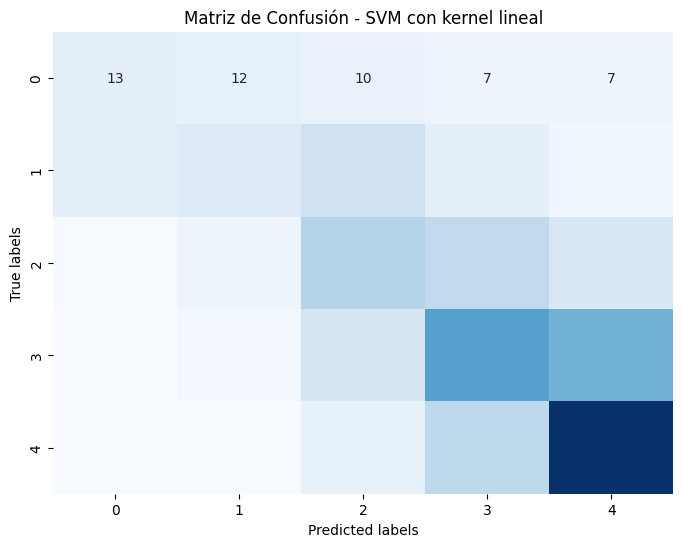

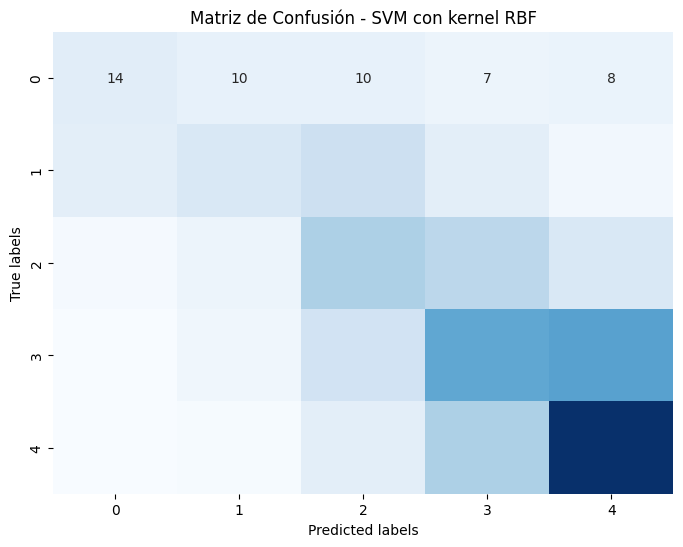

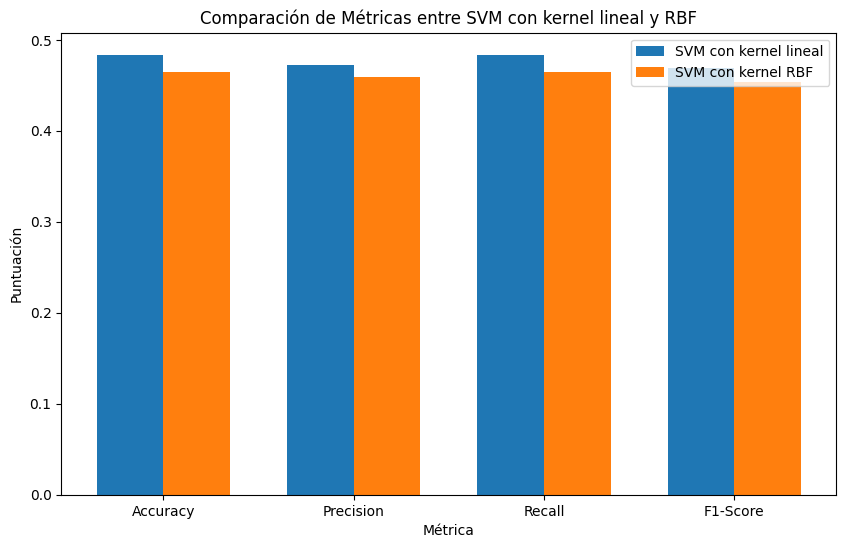

In [81]:
# Función para graficar una matriz de confusión
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Calcular la matriz de confusión para SVM con kernel lineal
conf_matrix_linear = confusion_matrix(y_test_s, y_pred_linear)
plot_confusion_matrix(conf_matrix_linear, 'Matriz de Confusión - SVM con kernel lineal')

# Calcular la matriz de confusión para SVM con kernel RBF
conf_matrix_rbf = confusion_matrix(y_test_s, y_pred_rbf)
plot_confusion_matrix(conf_matrix_rbf, 'Matriz de Confusión - SVM con kernel RBF')

# Graficar las métricas de cada modelo
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
linear_scores = [accuracy_linear] + [classification_report(y_test_s, y_pred_linear, output_dict=True)['weighted avg'][metric.lower()] for metric in metrics[1:]]
rbf_scores = [accuracy_rbf] + [classification_report(y_test_s, y_pred_rbf, output_dict=True)['weighted avg'][metric.lower()] for metric in metrics[1:]]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, linear_scores, bar_width, label='SVM con kernel lineal')
plt.bar(index + bar_width, rbf_scores, bar_width, label='SVM con kernel RBF')

plt.xlabel('Métrica')
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas entre SVM con kernel lineal y RBF')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.show()

Aunque la precisión de ambos modelos es comparable, la SVM con kernel RBF tiene una precisión ligeramente superior en general. Esto sugiere que, para este conjunto de datos específico, la SVM con kernel RBF puede ser ligeramente más adecuada para la tarea de clasificación. Para ambas clases 1 y 2, la SVM con kernel RBF muestra una mejor precisión, mientras que para las clases 4 y 5, la SVM con kernel lineal tiene una precisión ligeramente mejor.

### 3.2 Evaluación cualitativa

##  4. Resultados

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=353f6407-fc37-4ee9-8dc3-56903a752cdb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>